# COGS 181 Final Project
## By Sialoi Ta'a and Jay Buensuceso

In this project we decided to use the architecture for MobileNets founded in [this paper](https://arxiv.org/pdf/1704.04861.pdf). The dataset we'll be using is the cifar-10 dataset. In the cells below we show how using the MobileNets architecture implemented by PyTorch effectively and effiiciently trains the cifar-10 dataset with reasonable accuracy.

In [1]:
%pip install adabound #Tried this, didnt work

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import adabound

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.
images, _ = next(iter(testloader))
print(images.shape)

cuda:0
torch.Size([4, 3, 32, 32])


In [5]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
def ConvLayer(input_channels, output_channels, kernel_size, stride, padding=0, depth=False):
    if depth:
        return nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=output_channels, padding=padding, kernel_size=kernel_size, stride=stride, groups=input_channels),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU()
                         )
    else:
        return nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=output_channels, padding=padding, kernel_size=kernel_size, stride=stride),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU()
                         )

def Repeated_Layers(input_channels, kern1, kern2, stride1, stride2, padding1, padding2):
    return nn.Sequential(ConvLayer(input_channels, input_channels, kern1, stride1, padding1, depth=True),
                       ConvLayer(input_channels, input_channels, kern2, stride2, padding2),
                       )

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Starts at 32x32
        self.layers = []
        self.convLayer1 = ConvLayer(input_channels=3, output_channels=32, kernel_size=3, stride=2, padding=1) # Ends with 16x16
        self.layers.append(self.convLayer1)
        self.convDWLayer2 = ConvLayer(input_channels=32, output_channels=32, kernel_size=3, stride=1, padding=1, depth=True)
        self.layers.append(self.convDWLayer2)
        self.convLayer3 = ConvLayer(  input_channels=32, output_channels=64, kernel_size=1, stride=1)
        self.layers.append(self.convLayer3)
        self.convDWLayer4 = ConvLayer(input_channels=64, output_channels=64, kernel_size=3, stride=1, padding=1, depth=True) 
        self.layers.append(self.convDWLayer4)
        self.convLayer5 = ConvLayer(input_channels=64, output_channels=128, kernel_size=1, stride=1)
        self.layers.append(self.convLayer5)
        self.convDWLayer6 = ConvLayer(input_channels=128, output_channels=128, kernel_size=3, stride=1, padding=1, depth=True)
        self.layers.append(self.convDWLayer6)
        self.convLayer7 = ConvLayer(input_channels=128, output_channels=128, kernel_size=1, stride=1)
        self.layers.append(self.convLayer7)
        self.convDWLayer8 = ConvLayer(input_channels=128, output_channels=128, kernel_size=3, stride=1, padding=1, depth=True)
        self.layers.append(self.convDWLayer8)
        self.convLayer9 = ConvLayer(input_channels=128, output_channels=256, kernel_size=1, stride=1)
        self.layers.append(self.convLayer9)
        self.convDWLayer10 = ConvLayer(input_channels=256, output_channels=256, kernel_size=3, stride=1, padding=1, depth=True)
        self.layers.append(self.convDWLayer10)
        self.convLayer11 = ConvLayer(input_channels=256, output_channels=256, kernel_size=1, stride=1)
        self.layers.append(self.convLayer11)
        self.convDWLayer12 = ConvLayer(input_channels=256, output_channels=256, kernel_size=3, stride=2, padding=1, depth=True) # Ends with 8x8 with 512 channels
        self.layers.append(self.convDWLayer12)
        self.convLayer13 = ConvLayer(input_channels=256, output_channels=512, kernel_size=1, stride=1) # Ends with 8x8 with 512 channels
        self.layers.append(self.convLayer13)
        self.convBlockLayer14 = Repeated_Layers(input_channels=512, kern1=3, kern2=1, stride1=1, stride2=1, padding1=1, padding2=0)
        self.layers.append(self.convBlockLayer14)
        self.convBlockLayer15 = Repeated_Layers(input_channels=512, kern1=3, kern2=1, stride1=1, stride2=1, padding1=1, padding2=0)
        self.layers.append(self.convBlockLayer15)
        self.convBlockLayer16 = Repeated_Layers(input_channels=512, kern1=3, kern2=1, stride1=1, stride2=1, padding1=1, padding2=0)
        self.layers.append(self.convBlockLayer16)
        self.convBlockLayer17 = Repeated_Layers(input_channels=512, kern1=3, kern2=1, stride1=1, stride2=1, padding1=1, padding2=0)
        self.layers.append(self.convBlockLayer17)
        self.convBlockLayer18 = Repeated_Layers(input_channels=512, kern1=3, kern2=1, stride1=1, stride2=1, padding1=1, padding2=0)
        self.layers.append(self.convBlockLayer18)
        self.convDWLayer19 = ConvLayer(input_channels=512, output_channels=512, kernel_size=3, stride=2, padding=1, depth=True) # 4x4 with 512 channels
        self.layers.append(self.convDWLayer19)
        self.convLayer20 = ConvLayer(input_channels=512, output_channels=1024, kernel_size=1, stride=1)
        self.layers.append(self.convLayer20)
        self.convDWLayer21 = ConvLayer(input_channels=1024, output_channels=1024, kernel_size=3, stride=2, padding=1, depth=True) # 2x2 with 1024 channels
        self.layers.append(self.convDWLayer21)
        self.convLayer22 = ConvLayer(input_channels=1024, output_channels=1024, kernel_size=1, stride=1)
        self.layers.append(self.convLayer22)
        self.avgPoolLayer = nn.AvgPool2d(kernel_size=2, stride=1, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None) # Ends with 1x1 with 1024 channels
        self.layers.append(self.avgPoolLayer)
        self.flatten = nn.Flatten() # Ends with 1024 features
        self.layers.append(self.flatten)
        self.fullyConnectedLayer1 = nn.Linear(1024, 1000, bias=True, device=None, dtype=None)
        self.layers.append(self.fullyConnectedLayer1)
        self.fullyConnectedLayer2 = nn.Linear(1000, 10, bias=True, device=None, dtype=None)
        self.layers.append(self.fullyConnectedLayer2)
        self.softMaxLayer = nn.Softmax(1)
        self.layers.append(self.softMaxLayer)

    def forward(self, x):
        # print(x.shape) (4, 3, 32, 32) = 4 images each with 32 x 32 frames with 3 channels
        h = 0
        for i, layer in enumerate(self.layers):
            if i == 0:
                h = layer(x)
            else:
                h = layer(h)
            #print(f"Layer {i+1}, Output: {h.shape}")
        return h

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (convLayer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convDWLayer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convLayer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convDWLayer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convLayer5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1,

In [7]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(net.parameters(), lr=0.00005)


In [8]:
avg_losses = []   # Avg. losses.
epochs = 60       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data

        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.293
[epoch: 0, i:  1999] avg mini-batch loss: 2.268
[epoch: 0, i:  2999] avg mini-batch loss: 2.231
[epoch: 0, i:  3999] avg mini-batch loss: 2.225
[epoch: 0, i:  4999] avg mini-batch loss: 2.208
[epoch: 0, i:  5999] avg mini-batch loss: 2.199
[epoch: 0, i:  6999] avg mini-batch loss: 2.197
[epoch: 0, i:  7999] avg mini-batch loss: 2.192
[epoch: 0, i:  8999] avg mini-batch loss: 2.178
[epoch: 0, i:  9999] avg mini-batch loss: 2.183
[epoch: 0, i: 10999] avg mini-batch loss: 2.162
[epoch: 0, i: 11999] avg mini-batch loss: 2.168
[epoch: 1, i:   999] avg mini-batch loss: 2.155
[epoch: 1, i:  1999] avg mini-batch loss: 2.154
[epoch: 1, i:  2999] avg mini-batch loss: 2.148
[epoch: 1, i:  3999] avg mini-batch loss: 2.145
[epoch: 1, i:  4999] avg mini-batch loss: 2.148
[epoch: 1, i:  5999] avg mini-batch loss: 2.135
[epoch: 1, i:  6999] avg mini-batch loss: 2.131
[epoch: 1, i:  7999] avg mini-batch loss: 2.128
[epoch: 1, i:  8999] avg mini-batch loss

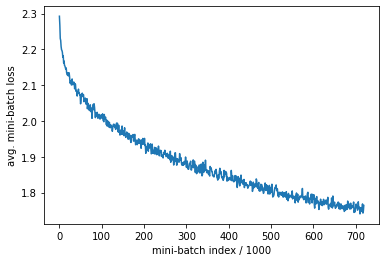

In [9]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

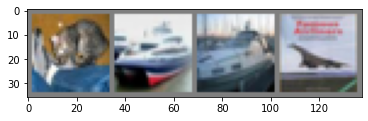

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane


In [10]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [11]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


In [12]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 82 %
Accuracy of  bird : 58 %
Accuracy of   cat : 52 %
Accuracy of  deer : 60 %
Accuracy of   dog : 45 %
Accuracy of  frog : 73 %
Accuracy of horse : 63 %
Accuracy of  ship : 77 %
Accuracy of truck : 74 %
